In [2]:
import time

import numpy as np
import pandas as pd
import seaborn as sns

from uncertainties import ufloat
from ctypes import c_double

import ROOT
ROOT.EnableImplicitMT()    # Tells ROOT to go parallel

In [22]:
import os

sig_tag  = 'stop_M600_580_ct2_2018'


bkg_dir = "/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/vtx_2018_v2/bkg"
sig_dir = "/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/vtx_2018_v2/sig"


sig_file = ROOT.TFile(os.path.join(sig_dir, f"{sig_tag}_hist.root"))
sig_hist = sig_file.MET200_evt.MET_pt_corr_vs_Max_vtx_PART_338_epoch_6.Clone()


bkg_file = ROOT.TFile(os.path.join(bkg_dir, f"all_2018_hist.root"))
bkg_hist = bkg_file.MET200_evt.MET_pt_corr_vs_Max_vtx_PART_338_epoch_6.Clone()

In [21]:
store.close()

In [23]:
x_binwidth = sig_hist.GetXaxis().GetBinWidth(1)
y_binwidth = sig_hist.GetYaxis().GetBinWidth(1)

In [24]:
MET_step = 50
MLScore_step = y_binwidth

MET_boundaryList = range(200+ MET_step, 1000+1, MET_step)
MLScore_boundaryList = np.arange(0.90, 1, MLScore_step)

In [25]:
def sig(s,b,b_err):
  return np.sqrt(2*((s+b)*np.log(((s+b)*(b+b_err*b_err))/(b*b+(s+b)*b_err*b_err+1e-100)) - 
                    (b*b/(b_err*b_err + 1e-100))*np.log(1+(b_err*b_err*s)/(b*(b+b_err*b_err)+1e-100))))

In [26]:
significances_dir = '/scratch-cbe/users/alikaan.gueven/AN_plots/ParT_hists/vtx_2018_v2/significances'
os.makedirs(significances_dir, exist_ok=True)

In [27]:
MET_step = MET_boundaryList[1] - MET_boundaryList[0]
MLScore_step = MLScore_boundaryList[1] - MLScore_boundaryList[0]

sigTable = pd.DataFrame(columns=range(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(MLScore_boundaryList[0], MLScore_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

bkgTable = pd.DataFrame(columns=range(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(MLScore_boundaryList[0], MLScore_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

bkgpredTable = pd.DataFrame(columns=range(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(MLScore_boundaryList[0], MLScore_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

signifTable = pd.DataFrame(columns=range(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(MLScore_boundaryList[0], MLScore_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

signifpredTable = pd.DataFrame(columns=range(MET_boundaryList[0], MET_boundaryList[-1]+MET_step, MET_step),
                 index=  np.arange(MLScore_boundaryList[0], MLScore_boundaryList[-1]+MLScore_step, MLScore_step),
                 dtype= float)

store = pd.HDFStore(os.path.join(significances_dir, 'dataframes.h5'))


    
for MET_boundary in MET_boundaryList:
    for MLScore_boundary in MLScore_boundaryList:
        
        hist = bkg_hist
        
        allBkg_SPRA = 0
        allBkg_SPRB = 0
        allBkg_SPRC = 0
        allBkg_SPRD = 0

        MET_lo = -1
        MET_up = hist.GetNbinsX()+1
        MET_bound = hist.GetXaxis().FindBin(MET_boundary)

        MLScore_lo = -1
        MLScore_up = hist.GetNbinsY()+1
        MLScore_bound = hist.GetYaxis().FindBin(MLScore_boundary)

        x = c_double(0.0)
        SPRA = ufloat(hist.IntegralAndError(MET_bound, MET_up, MLScore_bound, MLScore_up, x), x.value)
        SPRB = ufloat(hist.IntegralAndError(MET_bound, MET_up, MLScore_lo, MLScore_bound-1, x), x.value)
        SPRC = ufloat(hist.IntegralAndError(MET_lo, MET_bound-1, MLScore_bound, MLScore_up, x), x.value)
        SPRD = ufloat(hist.IntegralAndError(MET_lo, MET_bound-1, MLScore_lo, MLScore_bound-1, x), x.value)

        allBkg_SPRA = SPRA
        allBkg_SPRB = SPRB
        allBkg_SPRC = SPRC
        allBkg_SPRD = SPRD

        # print((allBkg_SPRA + allBkg_SPRB + allBkg_SPRC + allBkg_SPRD).n)
        # print(allBkg_SPRA,allBkg_SPRB,allBkg_SPRC,allBkg_SPRD)

        bkgEventYield = allBkg_SPRA
        bkgEventYield_pred = allBkg_SPRB / allBkg_SPRD * allBkg_SPRC

        ### SIGNAL PART
        MET_lo = -1
        MET_up = sig_hist.GetNbinsX()+1
        MET_bound = sig_hist.GetXaxis().FindBin(MET_boundary)

        MLScore_lo = -1
        MLScore_up = sig_hist.GetNbinsY()+1
        MLScore_bound = sig_hist.GetYaxis().FindBin(MLScore_boundary)

        x = c_double(0.0)
        SPRA = ufloat(sig_hist.IntegralAndError(MET_bound, MET_up, MLScore_bound, MLScore_up, x), x.value)
        SPRB = ufloat(sig_hist.IntegralAndError(MET_bound, MET_up, MLScore_lo, MLScore_bound-1, x), x.value)
        SPRC = ufloat(sig_hist.IntegralAndError(MET_lo, MET_bound-1, MLScore_bound, MLScore_up, x), x.value)
        SPRD = ufloat(sig_hist.IntegralAndError(MET_lo, MET_bound-1, MLScore_lo, MLScore_bound-1, x), x.value)

        sigEventYield = SPRA

        sigTable.loc[MLScore_boundary, MET_boundary] = round(sigEventYield.n, 3)
        bkgTable.loc[MLScore_boundary, MET_boundary] = round(bkgEventYield.n, 3)
        bkgpredTable.loc[MLScore_boundary, MET_boundary] = round(bkgEventYield_pred.n, 3)
        # if MLScore_boundary==20 and MET_boundary==650:
        #     print(bkgEventYield.s)
        # signifTable.loc[MLScore_boundary, MET_boundary] = round(sig(sigEventYield.n, bkgEventYield.n, bkgEventYield.s), 3)
        # signifpredTable.loc[MLScore_boundary, MET_boundary] = round(sig(sigEventYield.n, bkgEventYield_pred.n, bkgEventYield_pred.s), 3)
        # signifTable.loc[MLScore_boundary, MET_boundary] = round(sig(sigEventYield.n, bkgEventYield.n, 1e-50), 3)
        # signifpredTable.loc[MLScore_boundary, MET_boundary] = round(sig(sigEventYield.n, bkgEventYield_pred.n, 1e-50), 3)

        signifTable.loc[MLScore_boundary, MET_boundary] = round(sig(sigEventYield.n, bkgEventYield.n, 0.20 * bkgEventYield.n), 3)
        signifpredTable.loc[MLScore_boundary, MET_boundary] = round(sig(sigEventYield.n, bkgEventYield_pred.n, 0.20 * bkgEventYield.n), 3)
        # signifTable.loc[MLScore_boundary, MET_boundary] = round(sigEventYield.n / np.sqrt(bkgEventYield.n), 3)
        # signifpredTable.loc[MLScore_boundary, MET_boundary] = round(sigEventYield.n / np.sqrt(bkgEventYield_pred.n), 3)


store[sig_tag + '_sigTable'] = sigTable                    # save it
store[sig_tag + '_bkgTable'] = bkgTable                    # save it
store[sig_tag + '_bkgpredTable'] = bkgpredTable            # save it
store[sig_tag + '_signifTable'] = signifTable              # save it
store[sig_tag + '_signifpredTable'] = signifpredTable      # save it

# signifTable

In [9]:
# c1 = ROOT.TCanvas()
# tfile = ROOT.TFile(os.path.join(dir, "stop_M600_580_ct2_2018_hist.root"))
# thist = tfile.SP_SDVSecVtx_all.SDVSecVtx_mass.Clone()
# 
# # thist.GetXaxis().SetRangeUser(100, 600) 
# # thist.GetYaxis().SetRangeUser(100, 600) 
# thist.Draw("HIST")
# c1.Draw()




# print(thist.GetEntries())
# for i in tfile.GetListOfKeys():
#     print(i)

In [18]:
# store.close()
store.keys()

['/stop_M1000_980_ct2_2018_bkgTable',
 '/stop_M1000_980_ct2_2018_bkgpredTable',
 '/stop_M1000_980_ct2_2018_sigTable',
 '/stop_M1000_980_ct2_2018_signifTable',
 '/stop_M1000_980_ct2_2018_signifpredTable',
 '/stop_M600_580_ct2_2018_bkgTable',
 '/stop_M600_580_ct2_2018_bkgpredTable',
 '/stop_M600_580_ct2_2018_sigTable',
 '/stop_M600_580_ct2_2018_signifTable',
 '/stop_M600_580_ct2_2018_signifpredTable']

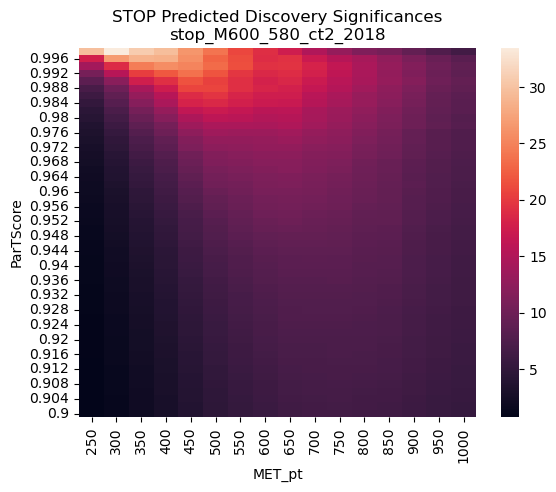

In [28]:
tag= sig_tag

s = sns.heatmap(store[tag + '_signifpredTable'])
s.set(xlabel='MET_pt', ylabel='ParTScore', title='STOP Predicted Discovery Significances\n'+tag);
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();

In [69]:
df = store[tag + '_signifpredTable']
df_values = df.values
np.max(df_values[~np.isnan(df_values)])

3.852

In [53]:
from matplotlib.colors import LogNorm, Normalize

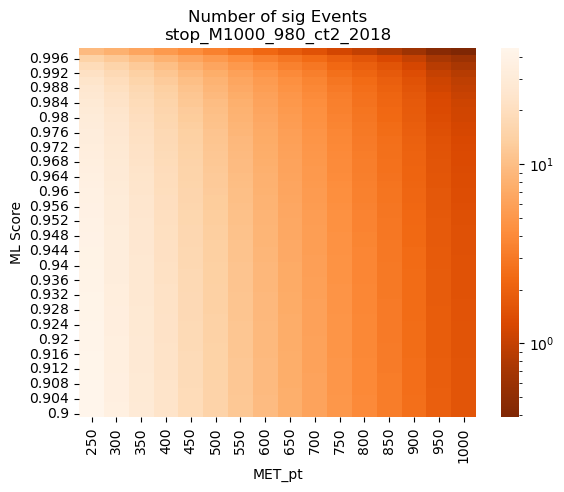

In [54]:
s = sns.heatmap(store[tag + '_sigTable'], norm=LogNorm(), cmap='Oranges_r')
s.set(xlabel='MET_pt', ylabel='ML Score', title='Number of sig Events\n'+tag);
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();

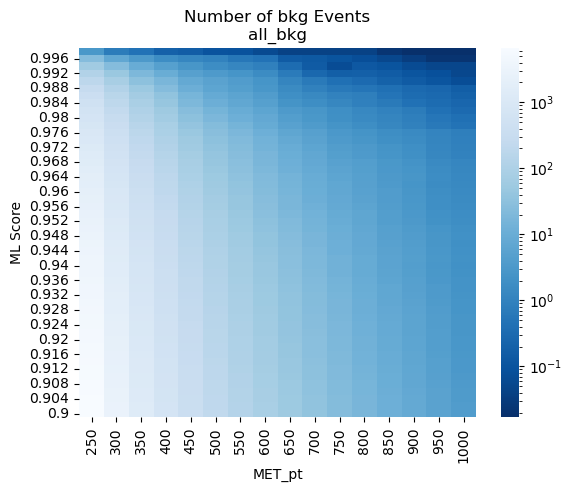

In [55]:
s = sns.heatmap(store[tag + '_bkgTable'], norm=LogNorm(), cmap='Blues_r')
s.set(xlabel='MET_pt', ylabel='ML Score', title='Number of bkg Events\n'+"all_bkg");
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();

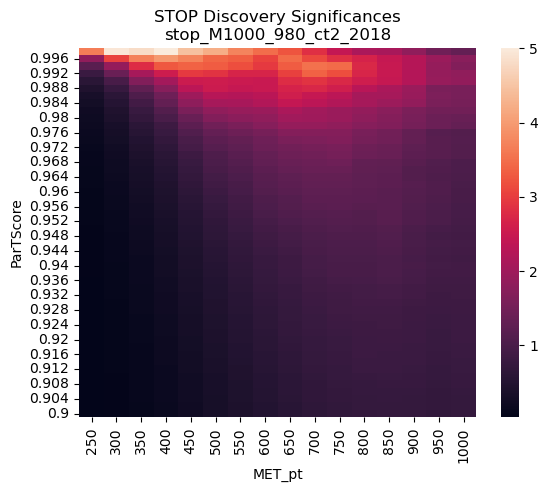

In [92]:
s = sns.heatmap(store[tag + '_signifTable'])
s.set(xlabel='MET_pt', ylabel='ParTScore', title='STOP Discovery Significances\n'+tag);
s.set_yticklabels([*map(lambda x: round(float(x.get_text()), 4), s.get_yticklabels())])
s.invert_yaxis();

In [59]:
# store[tag + '_signifTable']

In [83]:
df = store[tag + '_signifTable']
df_values = df.values
np.max(df_values[~np.isnan(df_values)])

4.546

In [66]:
df[~df.isna()]

,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.800,2.345,3.130,3.866,4.480,4.981,5.527,5.758,5.852,5.800,5.968,5.756,5.626,5.321
0.802,2.374,3.170,3.902,4.518,5.022,5.574,5.817,5.912,5.853,6.009,5.761,5.587,5.332
0.804,2.402,3.203,3.945,4.554,5.054,5.599,5.850,5.953,5.882,6.046,5.788,5.618,5.350
0.806,2.429,3.234,3.979,4.587,5.099,5.636,5.894,5.997,5.922,6.087,5.831,5.659,5.395
0.808,2.450,3.263,4.011,4.625,5.151,5.678,5.910,6.012,5.930,6.090,5.822,5.659,5.388
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.990,24.396,23.831,22.506,20.288,17.757,17.342,15.715,13.942,14.320,13.238,11.788,10.603,9.194
0.992,26.611,25.368,22.896,20.528,18.026,18.113,17.508,15.247,13.973,12.802,11.093,9.947,8.646
0.994,28.525,26.812,22.988,20.492,18.093,19.379,16.956,14.894,13.388,12.265,10.439,9.244,7.938
0.996,28.032,25.405,23.315,20.225,17.899,20.098,18.093,15.960,16.816,14.945,12.577,10.986,NaN


In [29]:
store[tag + '_sigTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,506.783,396.818,304.996,235.993,183.370,140.017,106.891,81.638,64.444,49.048,38.102,30.291,23.126,17.490,12.768,10.024
0.994,434.167,339.390,262.451,203.367,158.124,120.529,91.866,71.118,56.465,43.479,34.034,27.391,20.967,15.973,11.822,9.361
0.996,350.803,275.815,213.089,166.621,129.422,99.035,75.078,57.885,45.717,35.115,27.581,22.568,17.075,12.461,9.096,7.021
0.998,222.663,174.382,132.338,104.124,80.415,61.001,46.858,36.776,29.271,22.267,17.462,13.969,10.738,7.768,5.656,4.235


In [30]:
store[tag + '_bkgTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,114.502,46.643,19.564,10.121,4.979,3.482,2.597,1.660,0.697,0.274,0.173,0.189,0.150,0.109,0.084,0.053
0.994,60.627,25.035,9.249,4.600,2.673,1.747,1.181,0.883,0.338,0.143,0.067,0.122,0.101,0.064,0.051,0.051
0.996,24.961,7.522,3.265,1.716,1.214,0.961,0.583,0.458,0.147,0.133,0.100,0.074,0.053,0.034,0.021,0.021
0.998,3.039,0.734,0.463,0.195,0.160,0.098,0.090,0.060,0.042,0.042,0.042,0.042,0.022,0.017,0.017,0.017


In [90]:
store[tag + '_bkgpredTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,104.886,47.633,23.178,12.051,6.686,3.882,2.360,1.489,0.965,0.641,0.432,0.298,0.208,0.146,0.104,0.075
0.994,56.345,25.404,12.486,6.472,3.569,2.074,1.262,0.795,0.516,0.342,0.231,0.159,0.111,0.078,0.056,0.040
0.996,18.210,9.476,4.506,2.330,1.280,0.743,0.453,0.286,0.186,0.123,0.083,0.057,0.040,0.028,0.020,0.014
0.998,3.802,1.693,0.760,0.393,0.215,0.125,0.076,0.048,0.031,0.021,0.014,0.010,0.007,0.005,0.003,0.002


In [91]:
store[tag + '_bkgTable'][0.992:] / store[tag + '_bkgpredTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,1.091680,0.979216,0.844076,0.839847,0.744690,0.896960,1.100424,1.114842,0.722280,0.427457,0.400463,0.634228,0.721154,0.746575,0.807692,0.706667
0.994,1.075996,0.985475,0.740750,0.710754,0.748949,0.842334,0.935816,1.110692,0.655039,0.418129,0.290043,0.767296,0.909910,0.820513,0.910714,1.275000
0.996,1.370730,0.793795,0.724589,0.736481,0.948437,1.293405,1.286976,1.601399,0.790323,1.081301,1.204819,1.298246,1.325000,1.214286,1.050000,1.500000
0.998,0.799316,0.433550,0.609211,0.496183,0.744186,0.784000,1.184211,1.250000,1.354839,2.000000,3.000000,4.200000,3.142857,3.400000,5.666667,8.500000


In [31]:
store[tag + '_signifTable'][0.992:]

,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000
0.992,10.941,15.431,19.576,21.508,23.048,21.639,19.831,18.675,19.105,18.764,17.229,14.912,13.111,11.567,9.910,9.073
0.994,14.238,18.808,23.571,24.979,24.698,23.162,21.379,19.427,19.759,19.002,17.984,14.855,13.007,11.689,10.040,8.734
0.996,19.209,25.871,27.917,27.905,25.843,23.152,21.460,19.184,19.491,16.978,15.270,14.080,12.405,10.839,9.447,8.111
0.998,29.087,33.111,30.455,29.794,26.453,23.972,20.886,19.021,17.325,14.835,12.901,11.331,10.401,8.790,7.289,6.132


In [ ]:
# d.to_csv(sep = "|")
tableName = tag + '_bkgTable'
print(f"Printing {tableName} \n")
d = store[tableName]
s = d.to_markdown()
s = "| ParTScore/MET_pt" + s[6:]
print(s)

In [ ]:
for key in bkg_histDict.keys():
    print(key)

In [ ]:
c = ROOT.TCanvas("c1","myCanvas1",600,600)
h = bkg_histDict['zjetstonunuht2500_2018']
h.Draw("COLZ")
h.GetXaxis().SetRange(-1, 1000)
h.GetYaxis().SetRange(-1, 1000)
c.Draw()

In [ ]:
sig(15.903, 4.079, 0.4513)

In [ ]:
sig(5, 4.079, 0.4513)

In [ ]:
5 / 15.903

In [ ]:
store[tag + '_sigTable']

In [ ]:
tag = 'stop_1000_980_2'

s = sns.heatmap(store[tag + '_bkgTable'], cmap="Blues_r")
s.set(xlabel='MET_pt', ylabel='LxySig', title='STOP Events\n'+tag);
s.invert_yaxis();

In [ ]:
# d.to_csv(sep = "|")
tag = 'stop_1000_980_2'
d = store[tag + '_bkgTable']
s = d.to_markdown()
s = "| LxySig/MET_pt " + s[6:]

In [ ]:
print(f"{s}")

In [ ]:
# hist.GetYaxis().GetBinUpEdge(hist.GetYaxis().GetNbins())

In [ ]:
store['stop_1000_988_200_sigTable']

In [ ]:
store['stop_1000_988_200_bkgTable']

In [ ]:
store['stop_1000_988_200_signifTable']

In [ ]:
def sig(s,b,b_err):
  return np.sqrt(2*((s+b)*np.log(((s+b)*(b+b_err*b_err))/(b*b+(s+b)*b_err*b_err)) - 
                    (b*b/(b_err*b_err))*np.log(1+(b_err*b_err*s)/(b*(b+b_err*b_err)))))

In [ ]:
sig(0.2, 0.5, 1e-154)

In [ ]:
0.2 / np.sqrt(0.5)